<a href="https://colab.research.google.com/github/DannyDOcean/Toroidal-JEPA-SNN/blob/main/toroiadal_hive_model__JEPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 0: Environment Setup & Reproducibility

import os, random, math, time, json
import numpy as np
import torch

def set_seed(seed: int = 123):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For even more reproducibility (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Device: cuda
GPU: Tesla T4
Memory: 15.83 GB


In [ ]:
# Cell 1: Dependencies & Library Imports

!pip -q install einops wandb

import math, random, time, json
from dataclasses import dataclass, field
from typing import Dict, Tuple, List, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from einops import rearrange, repeat
import matplotlib.pyplot as plt

# Set matplotlib style for better plots
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ All imports successful")

✓ All imports successful


In [ ]:
# Cell 2: Model & Training Configuration

@dataclass
class CFG:
    # === Data ===
    img_size: int = 32
    in_ch: int = 3
    batch_size: int = 128
    num_workers: int = 2

    # === Training ===
    epochs_ssl: int = 100
    epochs_probe: int = 100
    lr: float = 3e-4
    wd: float = 1e-4
    use_amp: bool = True
    grad_clip: float = 1.0
    warmup_epochs: int = 10

    # === JEPA Architecture ===
    latent_dim: int = 256
    proj_dim: int = 256
    pred_dim: int = 256
    ema_decay: float = 0.996
    mask_ratio: float = 0.45

    # === Spiking & Homeostasis ===
    target_fr: float = 0.12          # Target firing rate (0.1-0.2 is healthy)
    fr_alpha: float = 2e-3            # EMA smoothing for FR tracking
    homeo_lambda: float = 0.8         # Homeostasis loss weight
    iso_lambda: float = 0.1           # Isotropy loss weight

    # === SNN Specifics ===
    spike_steps: int = 4              # Time steps per forward pass
    spike_noise: float = 0.02         # Noise to encourage spiking
    lif_tau: float = 2.0              # Membrane time constant
    lif_vth_init: float = 0.5         # Initial spike threshold

    # === Architecture ===
    tsa_width: int = 64               # Channel width
    depth: int = 3                    # Number of TSA blocks

    # === Calibration ===
    calib_band: float = 0.03          # Acceptable FR deviation
    calib_max_iters: int = 8          # Max calibration iterations
    calib_interval: int = 5           # Re-calibrate every N epochs

    def __post_init__(self):
        """Validate configuration."""
        assert 0 < self.target_fr < 1, "target_fr must be in (0, 1)"
        assert 0 < self.ema_decay < 1, "ema_decay must be in (0, 1)"
        assert self.mask_ratio > 0, "mask_ratio must be positive"

cfg = CFG()
print("Configuration:")
print("-" * 50)
for key, value in cfg.__dict__.items():
    print(f"  {key:20s}: {value}")
print("-" * 50)

Configuration:
--------------------------------------------------
  img_size            : 32
  in_ch               : 3
  batch_size          : 128
  num_workers         : 2
  epochs_ssl          : 100
  epochs_probe        : 100
  lr                  : 0.0003
  wd                  : 0.0001
  use_amp             : True
  grad_clip           : 1.0
  warmup_epochs       : 10
  latent_dim          : 256
  proj_dim            : 256
  pred_dim            : 256
  ema_decay           : 0.996
  mask_ratio          : 0.45
  target_fr           : 0.12
  fr_alpha            : 0.002
  homeo_lambda        : 0.8
  iso_lambda          : 0.1
  spike_steps         : 4
  spike_noise         : 0.02
  lif_tau             : 2.0
  lif_vth_init        : 0.5
  tsa_width           : 64
  depth               : 3
  calib_band          : 0.03
  calib_max_iters     : 8
  calib_interval      : 5
--------------------------------------------------


In [ ]:
# Cell 3: CIFAR-10 Data Pipeline with JEPA Masking

CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2470, 0.2435, 0.2616)

# Training augmentation pipeline
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(cfg.img_size, padding=4, padding_mode='reflect'),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.15))
])

# Test/validation transform
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

class JEPADataset(torch.utils.data.Dataset):
    """CIFAR-10 dataset with masked context-target pairs for JEPA."""

    def __init__(self, train: bool = True, mask_ratio: float = 0.45):
        self.ds = datasets.CIFAR10(root="./data", train=train, download=True)
        self.mask_ratio = mask_ratio
        self.train = train
        self.img_size = cfg.img_size

        # Pre-compute mask parameters
        self.mask_side = int(self.img_size * math.sqrt(self.mask_ratio) + 0.5)
        self.max_offset = self.img_size - self.mask_side

    def __len__(self) -> int:
        return len(self.ds)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, int]:
        img, label = self.ds[idx]

        # Apply augmentation
        x_target = train_transform(img) if self.train else test_transform(img)

        # Create masked context view
        x_context = x_target.clone()
        r = random.randint(0, self.max_offset)
        c = random.randint(0, self.max_offset)
        x_context[:, r:r + self.mask_side, c:c + self.mask_side] = 0.0

        return x_context, x_target, label

# Create dataloaders
train_dataset = JEPADataset(train=True, mask_ratio=cfg.mask_ratio)
test_dataset = JEPADataset(train=False, mask_ratio=cfg.mask_ratio)

train_dl = DataLoader(
    train_dataset,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=True,
    persistent_workers=True if cfg.num_workers > 0 else False,
    drop_last=True  # For batch norm stability
)

test_dl = DataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=True,
    persistent_workers=True if cfg.num_workers > 0 else False,
)

# Get class names
classes = datasets.CIFAR10(root="./data", train=False, download=True).classes
print(f"Classes ({len(classes)}): {', '.join(classes)}")
print(f"Train batches: {len(train_dl)} | Test batches: {len(test_dl)}")

100%|██████████| 170M/170M [00:03<00:00, 47.8MB/s]


Classes (10): airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
Train batches: 390 | Test batches: 79


In [ ]:
# Cell 4: Spiking Neural Network Architecture (LIF, TSA, Encoder)

class SpikeFn(torch.autograd.Function):
    """Differentiable spike function with smooth surrogate gradient."""

    @staticmethod
    def forward(ctx, x: torch.Tensor, gamma: float = 0.3) -> torch.Tensor:
        ctx.save_for_backward(x)
        ctx.gamma = gamma
        return (x > 0).to(x.dtype)

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor) -> Tuple[torch.Tensor, None]:
        (x,) = ctx.saved_tensors
        # Smooth surrogate: s'(x) ≈ 1 / (1 + |πx/2|)
        surrogate = 1.0 / (1.0 + (math.pi / 2.0) * x.abs())
        grad_input = grad_output * ctx.gamma * surrogate * (1.0 - surrogate)
        return grad_input, None

spike_fn = SpikeFn.apply


def GN(channels: int, groups: int = 8) -> nn.GroupNorm:
    """Group normalization with automatic group adjustment."""
    # Adjust groups if channel count isn't divisible
    while channels % groups != 0 and groups > 1:
        groups //= 2
    return nn.GroupNorm(groups, channels)


class LIF(nn.Module):
    """
    Leaky Integrate-and-Fire neuron with:
    - Learnable threshold
    - Multi-step dynamics
    - Optional noise injection
    - Detached state across batches
    """

    def __init__(
        self,
        tau: float = 2.0,
        v_th: float = 0.5,
        steps: int = 1,
        noise_std: float = 0.0
    ):
        super().__init__()
        self.tau = float(tau)
        self.v_th = nn.Parameter(torch.tensor(float(v_th)), requires_grad=True)
        self.steps = int(steps)
        self.noise_std = float(noise_std)

        # State variables (non-parameter buffers)
        self.register_buffer('v', None, persistent=False)
        self.last_spike_rate = None

    def reset_state(self):
        """Manually reset membrane potential."""
        self.v = None

    def _ensure_state(self, x: torch.Tensor):
        """Initialize state if needed."""
        if (self.v is None or
            self.v.shape != x.shape or
            self.v.device != x.device or
            self.v.dtype != x.dtype):
            self.v = torch.zeros_like(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._ensure_state(x)
        v = self.v.detach()  # Detach from previous batch
        spike_acc = 0.0

        for _ in range(self.steps):
            # Add noise if specified
            x_in = x
            if self.training and self.noise_std > 0:
                x_in = x_in + torch.randn_like(x_in) * self.noise_std

            # Leaky integration
            u = v + (x_in - v) / self.tau

            # Spike generation
            spike = spike_fn(u - self.v_th)

            # Update state (detached for next iteration)
            with torch.no_grad():
                v = v + (x_in - v) / self.tau
                v = v * (1.0 - spike)  # Reset on spike

            spike_acc = spike_acc + spike

        # Average spike rate across time steps
        spike_out = spike_acc / self.steps

        # Update state and track firing rate
        with torch.no_grad():
            self.v.copy_(v)
            self.last_spike_rate = spike_out.mean().item()

        return spike_out


class DepthwiseCircular(nn.Module):
    """Depthwise convolution with circular (toroidal) padding."""

    def __init__(self, channels: int, kernel_size: int = 3):
        super().__init__()
        self.dw = nn.Conv2d(
            channels, channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            groups=channels,
            padding_mode='circular',
            bias=False
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dw(x)


class TSAAdapter(nn.Module):
    """
    Toroidal Spike Adapter block:
    Input → Pointwise → LIF → Toroidal DW → LIF → Pointwise → Output
    With learnable excitability gates (gamma/beta) and residual connection.
    """

    def __init__(
        self,
        channels: int,
        hidden: Optional[int] = None,
        kernel_size: int = 3,
        steps: int = 1,
        noise: float = 0.0,
        tau: float = 2.0,
        vth: float = 0.5
    ):
        super().__init__()
        hidden = hidden or channels

        # First pointwise expansion
        self.pw1 = nn.Conv2d(channels, hidden, 1, bias=False)
        self.gn1 = GN(hidden)
        self.gamma1 = nn.Parameter(torch.ones(1, hidden, 1, 1))
        self.beta1 = nn.Parameter(torch.zeros(1, hidden, 1, 1))
        self.spike1 = LIF(tau=tau, v_th=vth, steps=steps, noise_std=noise)

        # Toroidal depthwise convolution
        self.dw = DepthwiseCircular(hidden, kernel_size=kernel_size)
        self.gn2 = GN(hidden)
        self.gamma2 = nn.Parameter(torch.ones(1, hidden, 1, 1))
        self.beta2 = nn.Parameter(torch.zeros(1, hidden, 1, 1))
        self.spike2 = LIF(tau=tau, v_th=vth, steps=steps, noise_std=noise)

        # Final pointwise projection
        self.pw2 = nn.Conv2d(hidden, channels, 1, bias=False)
        self.gn3 = GN(channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x

        # First pathway
        out = self.pw1(x)
        out = self.gn1(out)
        out = out * self.gamma1 + self.beta1  # Excitability modulation
        out = self.spike1(out)

        # Toroidal spatial processing
        out = self.dw(out)
        out = self.gn2(out)
        out = out * self.gamma2 + self.beta2
        out = self.spike2(out)

        # Output projection
        out = self.pw2(out)
        out = self.gn3(out)

        # Residual connection with ReLU
        return F.relu(out + residual)


class ToroidalSNNEncoder(nn.Module):
    """
    Toroidal Spiking Neural Network encoder.
    Stem → TSA blocks → Head → Global Average Pool → Projection
    """

    def __init__(
        self,
        in_channels: int = 3,
        width: int = 64,
        depth: int = 3,
        latent_dim: int = 256,
        steps: int = 1,
        noise: float = 0.0,
        tau: float = 2.0,
        vth: float = 0.5
    ):
        super().__init__()

        # Stem: initial feature extraction
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, width, 3, padding=1, padding_mode='circular', bias=False),
            GN(width),
            nn.ReLU(inplace=True),
        )

        # Stack of TSA blocks
        self.blocks = nn.Sequential(*[
            TSAAdapter(
                width,
                hidden=width,
                kernel_size=3,
                steps=steps,
                noise=noise,
                tau=tau,
                vth=vth
            )
            for _ in range(depth)
        ])

        # Output head
        self.head = nn.Sequential(
            nn.Conv2d(width, width, 1, bias=False),
            GN(width),
            nn.ReLU(inplace=True)
        )

        # Latent projection
        self.proj = nn.Linear(width, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)

        # Global average pooling
        x = x.mean(dim=[2, 3])

        # Project and normalize
        z = self.proj(x)
        return F.normalize(z, dim=-1)

    def reset_states(self):
        """Reset all LIF neuron states."""
        for module in self.modules():
            if isinstance(module, LIF):
                module.reset_state()

print("✓ Spiking architecture defined")

✓ Spiking architecture defined


In [ ]:
# Cell 5: JEPA Hybrid Model with Homeostatic Regularization

def cosine_loss(p: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
    """
    Cosine similarity loss for normalized vectors.
    Returns: 2 - 2 * cos(p, z) = 2(1 - cos(p, z))
    """
    return 2.0 - 2.0 * (p * z).sum(dim=-1)


def hadamard_matrix(n: int, device: Optional[torch.device] = None) -> torch.Tensor:
    """
    Generate Hadamard matrix for isotropy regularization.
    Pads to next power of 2 if needed.
    """
    # Find next power of 2
    m = 1
    while m < n:
        m <<= 1

    # Build Hadamard matrix recursively
    H = torch.tensor([[1.0]], device=device)
    while H.shape[0] < m:
        H = torch.cat([
            torch.cat([H, H], dim=1),
            torch.cat([H, -H], dim=1)
        ], dim=0)

    # Normalize and crop
    return (H[:n, :n] / math.sqrt(n))


class ProjectorPredictor(nn.Module):
    """
    Projector-Predictor head for JEPA.
    Projector: z → p (projected representation)
    Predictor: p → q (predicted target)
    """

    def __init__(self, in_dim: int, proj_dim: int, pred_dim: int):
        super().__init__()

        self.projector = nn.Sequential(
            nn.Linear(in_dim, proj_dim, bias=False),
            nn.BatchNorm1d(proj_dim),
            nn.ReLU(inplace=True),
            nn.Linear(proj_dim, proj_dim)
        )

        self.predictor = nn.Sequential(
            nn.Linear(proj_dim, pred_dim),
            nn.ReLU(inplace=True),
            nn.Linear(pred_dim, proj_dim)
        )

    def forward(self, z: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        p = F.normalize(self.projector(z), dim=-1)
        q = F.normalize(self.predictor(p), dim=-1)
        return p, q


class JEPAHybrid(nn.Module):
    """
    JEPA with Spiking Neural Networks and Homeostatic Regularization.

    Key components:
    - Online encoder (trainable)
    - Target encoder (EMA of online)
    - Projector-predictor head
    - Homeostasis & isotropy regularization
    """

    def __init__(self, cfg: CFG):
        super().__init__()
        self.cfg = cfg

        # Online encoder (trainable)
        self.enc_online = ToroidalSNNEncoder(
            in_channels=cfg.in_ch,
            width=cfg.tsa_width,
            depth=cfg.depth,
            latent_dim=cfg.latent_dim,
            steps=cfg.spike_steps,
            noise=cfg.spike_noise,
            tau=cfg.lif_tau,
            vth=cfg.lif_vth_init
        )

        # Projector-predictor
        self.pp = ProjectorPredictor(cfg.latent_dim, cfg.proj_dim, cfg.pred_dim)

        # Target encoder (EMA, frozen)
        self.enc_target = ToroidalSNNEncoder(
            in_channels=cfg.in_ch,
            width=cfg.tsa_width,
            depth=cfg.depth,
            latent_dim=cfg.latent_dim,
            steps=cfg.spike_steps,
            noise=0.0,  # No noise in target
            tau=cfg.lif_tau,
            vth=cfg.lif_vth_init
        )
        self._copy_params()
        for p in self.enc_target.parameters():
            p.requires_grad_(False)

        # Hadamard matrix for isotropy loss
        self.register_buffer("H", hadamard_matrix(cfg.proj_dim, device=device))

        # Firing rate EMA tracker
        self.register_buffer("fr_ema", torch.tensor(0.0))

    @torch.no_grad()
    def _copy_params(self):
        """Copy parameters from online to target encoder."""
        for p_target, p_online in zip(
            self.enc_target.parameters(),
            self.enc_online.parameters()
        ):
            p_target.data.copy_(p_online.data)

    @torch.no_grad()
    def ema_update(self):
        """Update target encoder with EMA of online encoder."""
        momentum = self.cfg.ema_decay
        for p_target, p_online in zip(
            self.enc_target.parameters(),
            self.enc_online.parameters()
        ):
            p_target.data.mul_(momentum).add_(p_online.data, alpha=1.0 - momentum)

    def _collect_firing_rates(self, module: nn.Module) -> List[float]:
        """Collect firing rates from all LIF neurons."""
        firing_rates = []
        for m in module.modules():
            if isinstance(m, LIF) and m.last_spike_rate is not None:
                firing_rates.append(m.last_spike_rate)
        return firing_rates

    def forward(
        self,
        x_context: torch.Tensor,
        x_target: torch.Tensor
    ) -> Tuple[torch.Tensor, Dict[str, float]]:
        """
        Forward pass with multiple loss components.

        Returns:
            total_loss: Combined loss
            aux: Dictionary of auxiliary metrics
        """
        # Online path: context → latent → projection → prediction
        z_online = self.enc_online(x_context)
        p, q = self.pp(z_online)

        # Target path: target → latent (no grad)
        with torch.no_grad():
            z_target = F.normalize(self.enc_target(x_target), dim=-1)

        # === Loss 1: Latent prediction ===
        loss_pred = cosine_loss(q, z_target).mean()

        # === Loss 2: Homeostasis (firing rate regulation) ===
        firing_rates = self._collect_firing_rates(self.enc_online)

        if firing_rates:
            fr_mean = torch.tensor(firing_rates, device=z_online.device).mean()

            # Update EMA
            with torch.no_grad():
                alpha = self.cfg.fr_alpha
                self.fr_ema = (1.0 - alpha) * self.fr_ema + alpha * fr_mean

            # Homeostasis loss: encourage target firing rate
            fr_target = self.cfg.target_fr
            loss_homeo = (torch.tensor(firing_rates, device=z_online.device) - fr_target).abs().mean()
        else:
            fr_mean = torch.tensor(0.0, device=z_online.device)
            loss_homeo = torch.tensor(0.0, device=z_online.device)

        # === Loss 3: Isotropy (prevent dimensional collapse) ===
        # Rotate projections with Hadamard matrix
        p_rotated = F.normalize(p @ self.H, dim=-1)

        # Variance across dimensions should be uniform (1/D)
        variance = p_rotated.var(dim=0).mean()
        target_variance = 1.0 / p_rotated.shape[1]
        loss_iso = (variance - target_variance).abs()

        # === Combined loss ===
        loss_total = (
            loss_pred +
            self.cfg.homeo_lambda * loss_homeo +
            self.cfg.iso_lambda * loss_iso
        )

        # Auxiliary metrics
        aux = {
            "loss_pred": loss_pred.item(),
            "loss_homeo": loss_homeo.item(),
            "loss_iso": loss_iso.item(),
            "fr_batch": fr_mean.item(),
            "fr_ema": self.fr_ema.item(),
            "variance": variance.item()
        }

        return loss_total, aux

print("✓ JEPA Hybrid model defined")

✓ JEPA Hybrid model defined


In [ ]:
# Cell 6: Model Initialization & Optimizer Setup
try:
    del model, opt, scaler
    print("Cleaned up previous model")
except NameError:
    pass

import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Cleared CUDA cache")

# Initialize model
model = JEPAHybrid(cfg).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Initialize optimizer
opt = torch.optim.AdamW(
    model.parameters(),
    lr=cfg.lr,
    weight_decay=cfg.wd,
    betas=(0.9, 0.999),
    eps=1e-8
)

# Mixed precision scaler
from torch.cuda.amp import GradScaler
scaler = GradScaler(enabled=(device.type == 'cuda' and cfg.use_amp))

print(f"✓ Model ready on {device}")
print(f"✓ Using AMP: {cfg.use_amp and device.type == 'cuda'}")

Cleared CUDA cache
Total parameters: 365,324
Trainable parameters: 314,374
✓ Model ready on cuda
✓ Using AMP: True


/tmp/ipython-input-561373652.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == 'cuda' and cfg.use_amp))


In [ ]:
# Cell 7: Firing Rate Calibration System

@torch.no_grad()
def calibrate_firing_rates(
    model: JEPAHybrid,
    dataloader: DataLoader,
    target: float = 0.12,
    band: float = 0.03,
    max_iters: int = 8,
    gamma_step: float = 1.15,
    vth_mult: float = 0.85
) -> float:
    """
    Calibrate firing rates by adjusting thresholds and excitability gates.

    Strategy:
    - If FR too low: decrease thresholds (easier to spike) & increase gamma (amplify input)
    - If FR too high: increase thresholds (harder to spike) & decrease gamma (dampen input)

    Args:
        model: JEPA model to calibrate
        dataloader: Data source for calibration
        target: Target firing rate
        band: Acceptable deviation (target ± band)
        max_iters: Maximum calibration iterations
        gamma_step: Multiplier for gamma adjustments
        vth_mult: Multiplier for threshold adjustments

    Returns:
        Final average firing rate
    """
    model.eval()
    data_iter = iter(dataloader)

    print(f"[Calibration] Target: {target:.3f} ± {band:.3f}")
    print("-" * 60)

    for iteration in range(max_iters):
        # Get batch
        try:
            _, x_target, _ = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            _, x_target, _ = next(data_iter)

        x_target = x_target.to(device, non_blocking=True)

        # Forward pass to collect firing rates
        _ = model.enc_online(x_target)

        # Collect FRs from all TSA adapters
        firing_rates = []
        for name, module in model.enc_online.named_modules():
            if isinstance(module, TSAAdapter):
                fr1 = getattr(module.spike1, "last_spike_rate", None)
                fr2 = getattr(module.spike2, "last_spike_rate", None)

                if fr1 is not None:
                    firing_rates.append(float(fr1))
                if fr2 is not None:
                    firing_rates.append(float(fr2))

        if not firing_rates:
            print("[Calibration] ⚠️  No firing rates detected - check architecture")
            return 0.0

        avg_fr = sum(firing_rates) / len(firing_rates)
        min_fr = min(firing_rates)
        max_fr = max(firing_rates)

        # Check if within acceptable band
        if (target - band) <= avg_fr <= (target + band):
            print(f"[Calibration] ✓ Converged in {iteration + 1} iteration(s)")
            print(f"              FR: {avg_fr:.4f} (min: {min_fr:.4f}, max: {max_fr:.4f})")
            return avg_fr

        # Adjust parameters based on whether FR is too low or too high
        if avg_fr < (target - band):
            # FR too low: make spiking easier
            adjustment = "↑ spiking (lower Vth, increase gamma)"
            for module in model.enc_online.modules():
                if isinstance(module, TSAAdapter):
                    # Lower thresholds
                    if hasattr(module.spike1, "v_th"):
                        module.spike1.v_th.data.mul_(vth_mult)
                    if hasattr(module.spike2, "v_th"):
                        module.spike2.v_th.data.mul_(vth_mult)

                    # Increase excitability
                    if hasattr(module, "gamma1"):
                        module.gamma1.data.mul_(gamma_step)
                    if hasattr(module, "gamma2"):
                        module.gamma2.data.mul_(gamma_step)
        else:
            # FR too high: make spiking harder
            adjustment = "↓ spiking (raise Vth, decrease gamma)"
            inv_vth = 1.0 / vth_mult
            inv_gamma = 1.0 / gamma_step

            for module in model.enc_online.modules():
                if isinstance(module, TSAAdapter):
                    # Raise thresholds
                    if hasattr(module.spike1, "v_th"):
                        module.spike1.v_th.data.mul_(inv_vth)
                    if hasattr(module.spike2, "v_th"):
                        module.spike2.v_th.data.mul_(inv_vth)

                    # Decrease excitability
                    if hasattr(module, "gamma1"):
                        module.gamma1.data.mul_(inv_gamma)
                    if hasattr(module, "gamma2"):
                        module.gamma2.data.mul_(inv_gamma)

        print(f"[Calibration] Iter {iteration + 1}/{max_iters}: "
              f"FR={avg_fr:.4f} → {adjustment}")

    print(f"[Calibration] ⚠️  Max iterations reached")
    print(f"              Final FR: {avg_fr:.4f} (min: {min_fr:.4f}, max: {max_fr:.4f})")
    return avg_fr


# Run initial calibration
print("=" * 60)
print("INITIAL FIRING RATE CALIBRATION")
print("=" * 60)
calibrated_fr = calibrate_firing_rates(
    model,
    train_dl,
    target=cfg.target_fr,
    band=cfg.calib_band,
    max_iters=cfg.calib_max_iters
)
print("=" * 60)

INITIAL FIRING RATE CALIBRATION
[Calibration] Target: 0.120 ± 0.030
------------------------------------------------------------
[Calibration] Iter 1/8: FR=0.1632 → ↓ spiking (raise Vth, decrease gamma)
[Calibration] ✓ Converged in 2 iteration(s)
              FR: 0.1041 (min: 0.0706, max: 0.1356)


In [ ]:
# Cell 8: Self-Supervised Learning Training Loop

from torch.cuda.amp import autocast, GradScaler

# Reinitialize optimizer after calibration (parameters may have changed)
opt = torch.optim.AdamW(
    model.parameters(),
    lr=cfg.lr,
    weight_decay=cfg.wd,
    betas=(0.9, 0.999)
)

scaler = GradScaler(enabled=(device.type == 'cuda' and cfg.use_amp))

# Learning rate scheduler with warmup
def lr_schedule(epoch: int) -> float:
    """Warmup + cosine annealing schedule."""
    if epoch < cfg.warmup_epochs:
        # Linear warmup
        return (epoch + 1) / cfg.warmup_epochs
    else:
        # Cosine annealing
        progress = (epoch - cfg.warmup_epochs) / max(1, cfg.epochs_ssl - cfg.warmup_epochs)
        return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_schedule)

# Training logs
train_logs = {
    "epoch": [],
    "loss": [],
    "pred": [],
    "homeo": [],
    "iso": [],
    "fr": [],
    "fr_ema": [],
    "lr": [],
    "time": []
}


def train_ssl_epoch(epoch: int) -> Dict[str, float]:
    """Train for one epoch."""
    model.train()

    # Periodic firing rate recalibration
    if epoch > 0 and epoch % cfg.calib_interval == 0:
        print(f"\n[Epoch {epoch}] Recalibrating firing rates...")
        calibrate_firing_rates(
            model, train_dl,
            target=cfg.target_fr,
            band=cfg.calib_band,
            max_iters=cfg.calib_max_iters // 2  # Fewer iters during training
        )
        print()

    metrics = {"loss": 0.0, "pred": 0.0, "homeo": 0.0, "iso": 0.0, "fr": 0.0, "fr_ema": 0.0}
    num_samples = 0

    for batch_idx, (x_ctx, x_tgt, _) in enumerate(train_dl):
        x_ctx = x_ctx.to(device, non_blocking=True)
        x_tgt = x_tgt.to(device, non_blocking=True)

        # Forward pass
        opt.zero_grad(set_to_none=True)

        with autocast(enabled=(device.type == 'cuda' and cfg.use_amp)):
            loss, aux = model(x_ctx, x_tgt)

        # Backward pass
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(opt)
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)

        # Optimizer step
        scaler.step(opt)
        scaler.update()

        # EMA update for target encoder
        model.ema_update()

        # Accumulate metrics
        batch_size = x_ctx.size(0)
        metrics["loss"] += loss.item() * batch_size
        metrics["pred"] += aux["loss_pred"] * batch_size
        metrics["homeo"] += aux["loss_homeo"] * batch_size
        metrics["iso"] += aux["loss_iso"] * batch_size
        metrics["fr"] += aux["fr_batch"] * batch_size
        metrics["fr_ema"] += aux["fr_ema"] * batch_size
        num_samples += batch_size

    # Average metrics
    for key in metrics:
        metrics[key] /= max(num_samples, 1)

    return metrics


def train_ssl():
    """Full SSL training loop."""
    print("=" * 80)
    print(f"SELF-SUPERVISED LEARNING ({cfg.epochs_ssl} epochs)")
    print("=" * 80)

    best_loss = float('inf')

    for epoch in range(cfg.epochs_ssl):
        epoch_start = time.time()

        # Train one epoch
        metrics = train_ssl_epoch(epoch)

        # Step scheduler
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

        # Log metrics
        epoch_time = time.time() - epoch_start
        train_logs["epoch"].append(epoch + 1)
        train_logs["loss"].append(metrics["loss"])
        train_logs["pred"].append(metrics["pred"])
        train_logs["homeo"].append(metrics["homeo"])
        train_logs["iso"].append(metrics["iso"])
        train_logs["fr"].append(metrics["fr"])
        train_logs["fr_ema"].append(metrics["fr_ema"])
        train_logs["lr"].append(current_lr)
        train_logs["time"].append(epoch_time)

        # Print progress
        print(f"[SSL] Epoch {epoch + 1:04d}/{cfg.epochs_ssl} | "
              f"Loss: {metrics['loss']:.4f} "
              f"(pred: {metrics['pred']:.4f}, "
              f"homeo: {metrics['homeo']:.4f}, "
              f"iso: {metrics['iso']:.4f}) | "
              f"FR: {metrics['fr']:.3f} (EMA: {metrics['fr_ema']:.3f}) | "
              f"LR: {current_lr:.2e} | "
              f"Time: {epoch_time:.1f}s")

        # Save checkpoints
        if metrics["loss"] < best_loss:
            best_loss = metrics["loss"]

        if (epoch + 1) % 50 == 0 or (epoch + 1) == cfg.epochs_ssl:
            checkpoint = {
                "epoch": epoch + 1,
                "model_state": model.state_dict(),
                "optimizer_state": opt.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "scaler_state": scaler.state_dict(),
                "cfg": cfg.__dict__,
                "logs": train_logs,
                "best_loss": best_loss
            }
            ckpt_path = f"ssl_checkpoint_epoch_{epoch + 1:04d}.pt"
            torch.save(checkpoint, ckpt_path)
            print(f"           └─ Saved checkpoint: {ckpt_path}")

    print("=" * 80)
    print(f"✓ SSL training complete! Best loss: {best_loss:.4f}")
    print("=" * 80)


# Start training
train_ssl()

/tmp/ipython-input-3012423674.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == 'cuda' and cfg.use_amp))


SELF-SUPERVISED LEARNING (100 epochs)


/tmp/ipython-input-3012423674.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda' and cfg.use_amp)):


[SSL] Epoch 0001/100 | Loss: 0.3713 (pred: 0.3470, homeo: 0.0299, iso: 0.0029) | FR: 0.091 (EMA: 0.028) | LR: 6.00e-05 | Time: 172.5s
[SSL] Epoch 0002/100 | Loss: 0.0323 (pred: 0.0085, homeo: 0.0294, iso: 0.0032) | FR: 0.092 (EMA: 0.062) | LR: 9.00e-05 | Time: 165.7s
[SSL] Epoch 0003/100 | Loss: 0.0311 (pred: 0.0075, homeo: 0.0291, iso: 0.0031) | FR: 0.093 (EMA: 0.078) | LR: 1.20e-04 | Time: 165.2s
[SSL] Epoch 0004/100 | Loss: 0.0301 (pred: 0.0068, homeo: 0.0287, iso: 0.0031) | FR: 0.094 (EMA: 0.087) | LR: 1.50e-04 | Time: 165.3s
[SSL] Epoch 0005/100 | Loss: 0.0284 (pred: 0.0061, homeo: 0.0275, iso: 0.0030) | FR: 0.096 (EMA: 0.091) | LR: 1.80e-04 | Time: 165.0s

[Epoch 5] Recalibrating firing rates...
[Calibration] Target: 0.120 ± 0.030
------------------------------------------------------------
[Calibration] ✓ Converged in 1 iteration(s)
              FR: 0.1120 (min: 0.0786, max: 0.1458)

[SSL] Epoch 0006/100 | Loss: 0.0310 (pred: 0.0093, homeo: 0.0268, iso: 0.0031) | FR: 0.096 (EMA

In [ ]:
# Cell 9: Linear Probe Evaluation

print("=" * 80)
print("LINEAR PROBE EVALUATION")
print("=" * 80)

# Freeze encoder
for param in model.enc_online.parameters():
    param.requires_grad_(False)

encoder = model.enc_online.eval()
print("✓ Encoder frozen")

# Linear classifier
classifier = nn.Linear(cfg.latent_dim, 10).to(device)
opt_probe = torch.optim.AdamW(
    classifier.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

print(f"✓ Classifier initialized ({cfg.latent_dim} → 10)")


@torch.no_grad()
def extract_features(dataloader: DataLoader) -> Tuple[torch.Tensor, torch.Tensor]:
    """Extract features and labels from dataset."""
    features_list = []
    labels_list = []

    for _, x_target, labels in dataloader:
        x_target = x_target.to(device, non_blocking=True)
        features = encoder(x_target)
        features_list.append(features.cpu())
        labels_list.append(labels)

    features = torch.cat(features_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    return features, labels


print("\nExtracting features...")
X_train, y_train = extract_features(train_dl)
X_test, y_test = extract_features(test_dl)
print(f"✓ Train features: {X_train.shape}")
print(f"✓ Test features: {X_test.shape}")

# Create new dataloaders for probe
probe_train_ds = torch.utils.data.TensorDataset(X_train, y_train)
probe_test_ds = torch.utils.data.TensorDataset(X_test, y_test)

probe_train_dl = DataLoader(
    probe_train_ds,
    batch_size=256,
    shuffle=True,
    num_workers=0  # Already in memory
)
probe_test_dl = DataLoader(
    probe_test_ds,
    batch_size=256,
    shuffle=False,
    num_workers=0
)


def compute_accuracy(logits: torch.Tensor, labels: torch.Tensor) -> float:
    """Compute classification accuracy."""
    predictions = logits.argmax(dim=1)
    correct = (predictions == labels).float().sum()
    return (correct / labels.size(0)).item()


# Probe training logs
probe_logs = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

print("\n" + "-" * 80)
print("Training linear probe...")
print("-" * 80)

best_test_acc = 0.0

for epoch in range(cfg.epochs_probe):
    # === Training ===
    classifier.train()
    train_loss_sum = 0.0
    train_acc_sum = 0.0
    train_samples = 0

    for features, labels in probe_train_dl:
        features = features.to(device)
        labels = labels.to(device)

        # Forward
        opt_probe.zero_grad(set_to_none=True)
        logits = classifier(features)
        loss = F.cross_entropy(logits, labels)

        # Backward
        loss.backward()
        opt_probe.step()

        # Metrics
        batch_size = features.size(0)
        train_loss_sum += loss.item() * batch_size
        train_acc_sum += compute_accuracy(logits, labels) * batch_size
        train_samples += batch_size

    train_loss = train_loss_sum / train_samples
    train_acc = train_acc_sum / train_samples

    # === Evaluation ===
    classifier.eval()
    test_loss_sum = 0.0
    test_acc_sum = 0.0
    test_samples = 0

    with torch.no_grad():
        for features, labels in probe_test_dl:
            features = features.to(device)
            labels = labels.to(device)

            logits = classifier(features)
            loss = F.cross_entropy(logits, labels)

            batch_size = features.size(0)
            test_loss_sum += loss.item() * batch_size
            test_acc_sum += compute_accuracy(logits, labels) * batch_size
            test_samples += batch_size

    test_loss = test_loss_sum / test_samples
    test_acc = test_acc_sum / test_samples

    # Log
    probe_logs["epoch"].append(epoch + 1)
    probe_logs["train_loss"].append(train_loss)
    probe_logs["train_acc"].append(train_acc)
    probe_logs["test_loss"].append(test_loss)
    probe_logs["test_acc"].append(test_acc)

    # Track best
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_marker = " ★"
    else:
        best_marker = ""

    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0 or (epoch + 1) == cfg.epochs_probe:
        print(f"[Probe] Epoch {epoch + 1:03d}/{cfg.epochs_probe} | "
              f"Train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
              f"Test: loss={test_loss:.4f}, acc={test_acc:.4f}{best_marker}")

print("-" * 80)
print(f"✓ Probe training complete! Best test accuracy: {best_test_acc:.4f}")
print("=" * 80)

LINEAR PROBE EVALUATION
✓ Encoder frozen
✓ Classifier initialized (256 → 10)

Extracting features...
✓ Train features: torch.Size([49920, 256])
✓ Test features: torch.Size([10000, 256])

--------------------------------------------------------------------------------
Training linear probe...
--------------------------------------------------------------------------------
[Probe] Epoch 001/100 | Train: loss=2.2428, acc=0.1958 | Test: loss=2.1447, acc=0.2541 ★
[Probe] Epoch 010/100 | Train: loss=2.0165, acc=0.2695 | Test: loss=1.8995, acc=0.3204
[Probe] Epoch 020/100 | Train: loss=1.9723, acc=0.2864 | Test: loss=1.8538, acc=0.3335 ★
[Probe] Epoch 030/100 | Train: loss=1.9500, acc=0.2970 | Test: loss=1.8281, acc=0.3449 ★
[Probe] Epoch 040/100 | Train: loss=1.9357, acc=0.3025 | Test: loss=1.8131, acc=0.3499
[Probe] Epoch 050/100 | Train: loss=1.9260, acc=0.3066 | Test: loss=1.8020, acc=0.3569
[Probe] Epoch 060/100 | Train: loss=1.9185, acc=0.3098 | Test: loss=1.7933, acc=0.3594
[Probe] Epo

GENERATING ANALYSIS & VISUALIZATIONS
Output directory: results/20251008_131525

Generating confusion matrix...


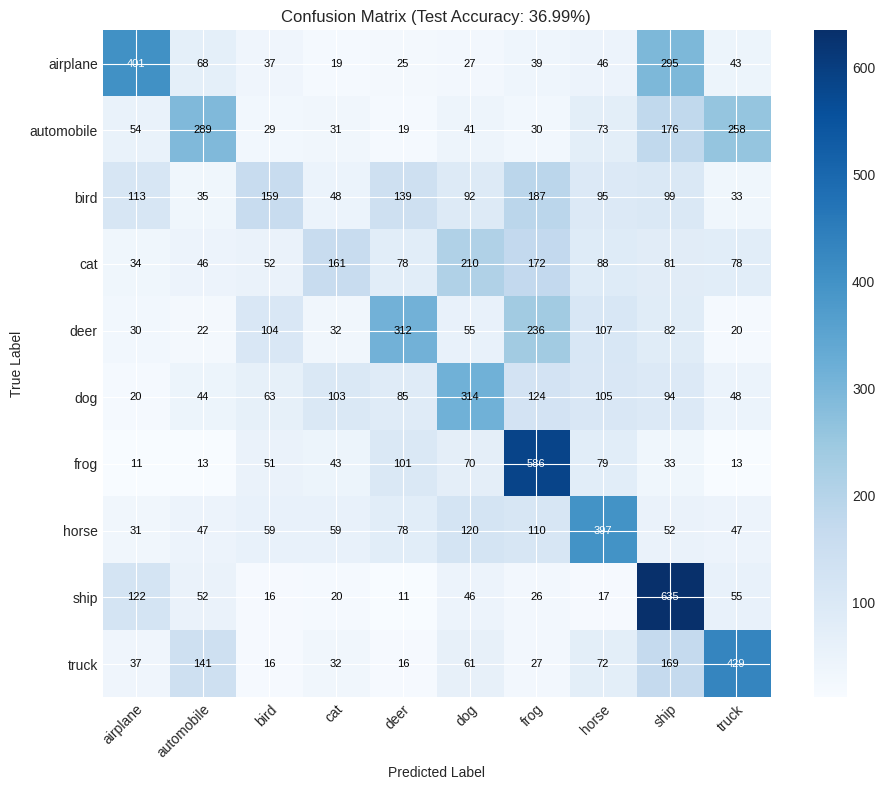

✓ Saved: confusion_matrix.png
Generating per-class accuracy...


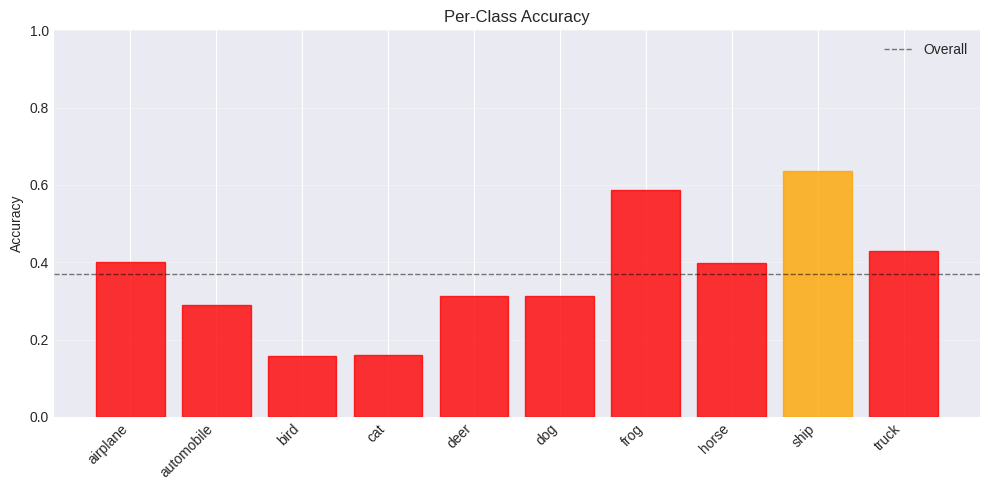

✓ Saved: per_class_accuracy.png
Generating PCA visualization...


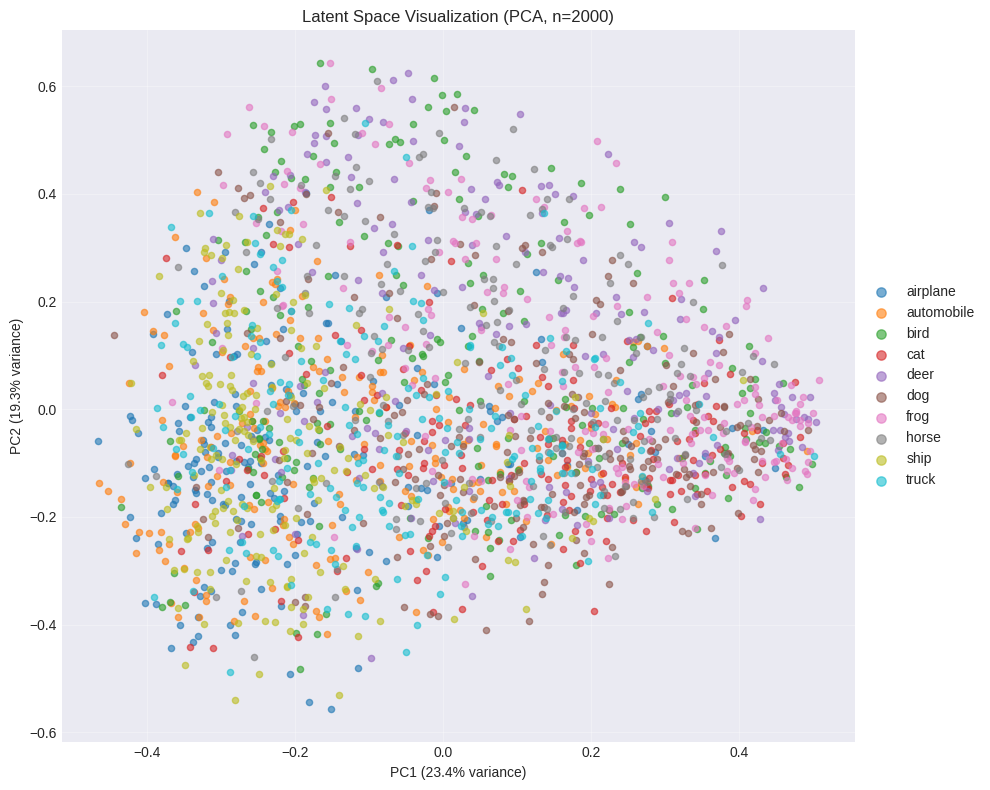

✓ Saved: latent_pca.png
Analyzing firing rates...


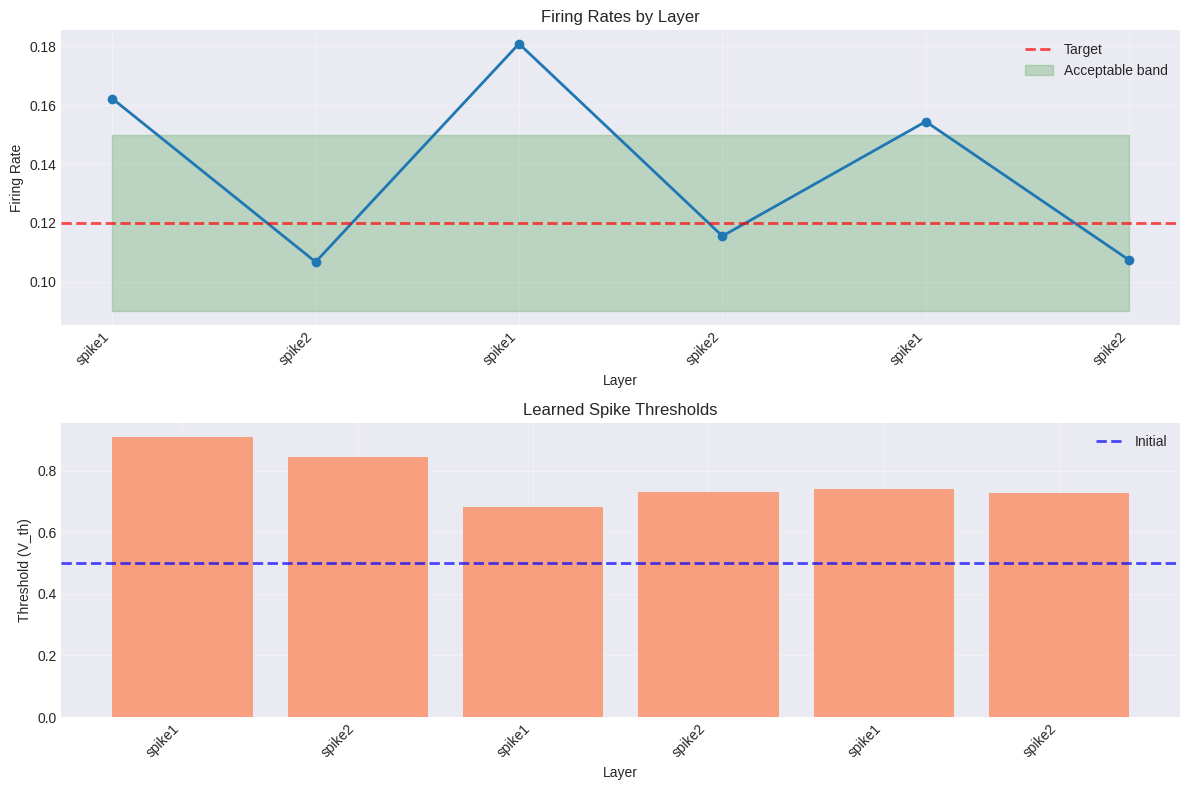

✓ Saved: firing_rate_analysis.png
  Average firing rate: 0.1379
  Target: 0.1200 ± 0.0300
Generating training curves...


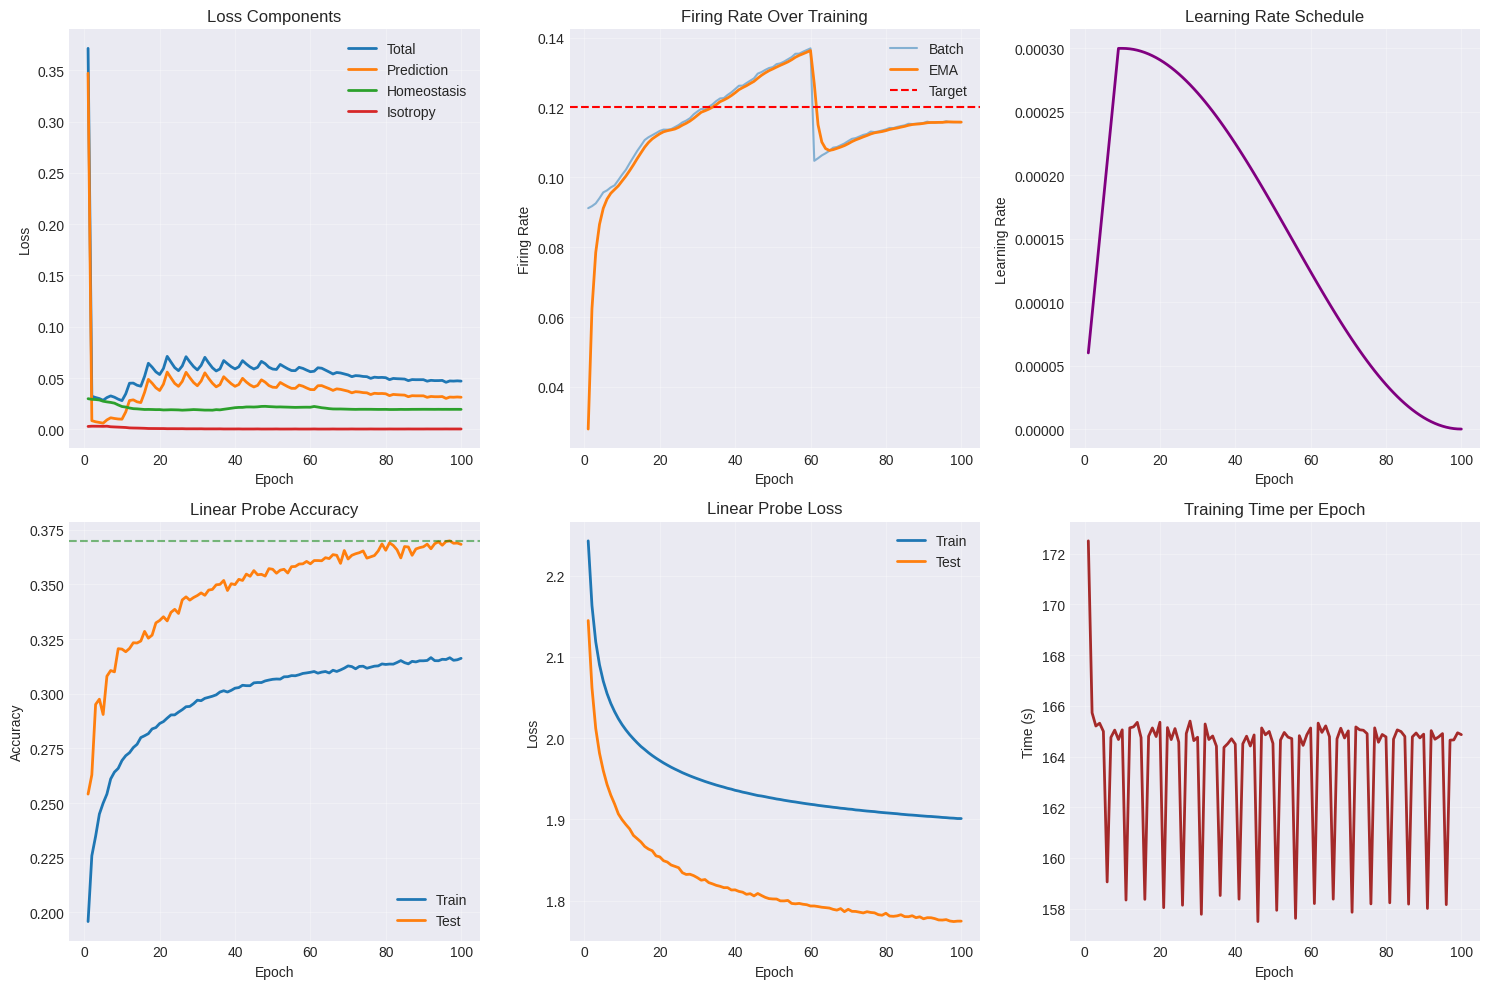

✓ Saved: training_curves.png

Saving metrics...
✓ Saved: metrics.json

Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    airplane     0.4701    0.4010    0.4328      1000
  automobile     0.3818    0.2890    0.3290      1000
        bird     0.2713    0.1590    0.2005      1000
         cat     0.2938    0.1610    0.2080      1000
        deer     0.3611    0.3120    0.3348      1000
         dog     0.3031    0.3140    0.3084      1000
        frog     0.3813    0.5860    0.4620      1000
       horse     0.3679    0.3970    0.3819      1000
        ship     0.3700    0.6350    0.4676      1000
       truck     0.4189    0.4290    0.4239      1000

    accuracy                         0.3683     10000
   macro avg     0.3619    0.3683    0.3549     10000
weighted avg     0.3619    0.3683    0.3549     10000

✓ Saved: classification_report.txt

Generating HTML report...
✓ Sa

In [ ]:
# Cell 10: Results Analysis & Visualization

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import numpy as np

print("=" * 80)
print("GENERATING ANALYSIS & VISUALIZATIONS")
print("=" * 80)

# Create output directory
run_id = time.strftime("%Y%m%d_%H%M%S")
output_dir = f"results/{run_id}"
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# === Collect predictions ===
print("\nCollecting predictions...")
all_predictions = []
all_labels = []

classifier.eval()
with torch.no_grad():
    for features, labels in probe_test_dl:
        features = features.to(device)
        logits = classifier(features)
        predictions = logits.argmax(dim=1).cpu().numpy()

        all_predictions.append(predictions)
        all_labels.append(labels.numpy())

y_pred = np.concatenate(all_predictions)
y_true = np.concatenate(all_labels)

# === Confusion Matrix ===
print("Generating confusion matrix...")
cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(10),
    yticks=np.arange(10),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Predicted Label',
    ylabel='True Label',
    title=f'Confusion Matrix (Test Accuracy: {best_test_acc:.2%})'
)

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
thresh = cm.max() / 2.0
for i in range(10):
    for j in range(10):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=8)

plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png", dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Saved: confusion_matrix.png")

# === Per-Class Accuracy ===
print("Generating per-class accuracy...")
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(range(10), per_class_acc, color='steelblue', alpha=0.8)

# Color code bars
for i, bar in enumerate(bars):
    if per_class_acc[i] >= 0.8:
        bar.set_color('green')
    elif per_class_acc[i] >= 0.6:
        bar.set_color('orange')
    else:
        bar.set_color('red')

ax.set(
    xticks=range(10),
    xticklabels=classes,
    ylabel='Accuracy',
    title='Per-Class Accuracy',
    ylim=[0, 1]
)
ax.axhline(y=best_test_acc, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Overall')
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{output_dir}/per_class_accuracy.png", dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Saved: per_class_accuracy.png")

# === PCA Visualization ===
print("Generating PCA visualization...")
# Sample subset for visualization
n_samples = min(2000, len(X_test))
indices = np.random.choice(len(X_test), n_samples, replace=False)
Z_subset = X_test[indices].numpy()
y_subset = y_test[indices].numpy()

# PCA
pca = PCA(n_components=2)
Z_2d = pca.fit_transform(Z_subset)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
scatter_plots = []
for class_idx in range(10):
    mask = y_subset == class_idx
    scatter = ax.scatter(
        Z_2d[mask, 0],
        Z_2d[mask, 1],
        s=20,
        label=classes[class_idx],
        alpha=0.6
    )
    scatter_plots.append(scatter)

ax.set(
    xlabel=f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)',
    ylabel=f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)',
    title=f'Latent Space Visualization (PCA, n={n_samples})'
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=1.5)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{output_dir}/latent_pca.png", dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Saved: latent_pca.png")

# === Firing Rate Analysis ===
print("Analyzing firing rates...")
# Run forward pass to update firing rates
with torch.no_grad():
    sample_batch = next(iter(test_dl))[1].to(device)
    _ = encoder(sample_batch)

# Collect firing rates
fr_data = []
for name, module in encoder.named_modules():
    if isinstance(module, LIF) and module.last_spike_rate is not None:
        fr_data.append({
            'layer': name,
            'rate': module.last_spike_rate,
            'threshold': module.v_th.item() if hasattr(module, 'v_th') else None
        })

if fr_data:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Firing rates
    rates = [d['rate'] for d in fr_data]
    labels = [d['layer'].split('.')[-1] for d in fr_data]

    ax1.plot(range(len(rates)), rates, marker='o', linewidth=2, markersize=6)
    ax1.axhline(y=cfg.target_fr, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Target')
    ax1.fill_between(range(len(rates)),
                      cfg.target_fr - cfg.calib_band,
                      cfg.target_fr + cfg.calib_band,
                      alpha=0.2, color='green', label='Acceptable band')
    ax1.set(
        xlabel='Layer',
        ylabel='Firing Rate',
        title='Firing Rates by Layer',
        xticks=range(len(rates)),
        xticklabels=labels
    )
    ax1.legend()
    ax1.grid(alpha=0.3)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

    # Thresholds
    thresholds = [d['threshold'] for d in fr_data if d['threshold'] is not None]
    thresh_labels = [d['layer'].split('.')[-1] for d in fr_data if d['threshold'] is not None]

    if thresholds:
        ax2.bar(range(len(thresholds)), thresholds, color='coral', alpha=0.7)
        ax2.axhline(y=cfg.lif_vth_init, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Initial')
        ax2.set(
            xlabel='Layer',
            ylabel='Threshold (V_th)',
            title='Learned Spike Thresholds',
            xticks=range(len(thresholds)),
            xticklabels=thresh_labels
        )
        ax2.legend()
        ax2.grid(alpha=0.3)
        plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.savefig(f"{output_dir}/firing_rate_analysis.png", dpi=200, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: firing_rate_analysis.png")

    avg_fr = np.mean(rates)
    print(f"  Average firing rate: {avg_fr:.4f}")
    print(f"  Target: {cfg.target_fr:.4f} ± {cfg.calib_band:.4f}")

# === Training Curves ===
print("Generating training curves...")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Loss components
axes[0].plot(train_logs["epoch"], train_logs["loss"], label='Total', linewidth=2)
axes[0].plot(train_logs["epoch"], train_logs["pred"], label='Prediction', linewidth=2)
axes[0].plot(train_logs["epoch"], train_logs["homeo"], label='Homeostasis', linewidth=2)
axes[0].plot(train_logs["epoch"], train_logs["iso"], label='Isotropy', linewidth=2)
axes[0].set(xlabel='Epoch', ylabel='Loss', title='Loss Components')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Firing rate
axes[1].plot(train_logs["epoch"], train_logs["fr"], label='Batch', alpha=0.5)
axes[1].plot(train_logs["epoch"], train_logs["fr_ema"], label='EMA', linewidth=2)
axes[1].axhline(y=cfg.target_fr, color='red', linestyle='--', label='Target')
axes[1].set(xlabel='Epoch', ylabel='Firing Rate', title='Firing Rate Over Training')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Learning rate
axes[2].plot(train_logs["epoch"], train_logs["lr"], linewidth=2, color='purple')
axes[2].set(xlabel='Epoch', ylabel='Learning Rate', title='Learning Rate Schedule')
axes[2].grid(alpha=0.3)

# Probe accuracy
axes[3].plot(probe_logs["epoch"], probe_logs["train_acc"], label='Train', linewidth=2)
axes[3].plot(probe_logs["epoch"], probe_logs["test_acc"], label='Test', linewidth=2)
axes[3].axhline(y=best_test_acc, color='green', linestyle='--', alpha=0.5)
axes[3].set(xlabel='Epoch', ylabel='Accuracy', title='Linear Probe Accuracy')
axes[3].legend()
axes[3].grid(alpha=0.3)

# Probe loss
axes[4].plot(probe_logs["epoch"], probe_logs["train_loss"], label='Train', linewidth=2)
axes[4].plot(probe_logs["epoch"], probe_logs["test_loss"], label='Test', linewidth=2)
axes[4].set(xlabel='Epoch', ylabel='Loss', title='Linear Probe Loss')
axes[4].legend()
axes[4].grid(alpha=0.3)

# Time per epoch
axes[5].plot(train_logs["epoch"], train_logs["time"], linewidth=2, color='brown')
axes[5].set(xlabel='Epoch', ylabel='Time (s)', title='Training Time per Epoch')
axes[5].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/training_curves.png", dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Saved: training_curves.png")

# === Save Metrics ===
print("\nSaving metrics...")
metrics = {
    "run_id": run_id,
    "config": cfg.__dict__,
    "final_metrics": {
        "test_accuracy": float(best_test_acc),
        "avg_firing_rate": float(np.mean(rates)) if fr_data else None,
        "target_firing_rate": float(cfg.target_fr),
        "final_ssl_loss": float(train_logs["loss"][-1]),
        "per_class_accuracy": {classes[i]: float(per_class_acc[i]) for i in range(10)}
    },
    "training_logs": {
        "ssl": train_logs,
        "probe": probe_logs
    }
}

with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print(f"✓ Saved: metrics.json")

# === Classification Report ===
print("\nClassification Report:")
print("-" * 80)
report = classification_report(y_true, y_pred, target_names=classes, digits=4)
print(report)

with open(f"{output_dir}/classification_report.txt", "w") as f:
    f.write(report)
print(f"✓ Saved: classification_report.txt")

# === HTML Report ===
print("\nGenerating HTML report...")
html_report = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Toroidal JEPA Spike - {run_id}</title>
    <style>
        body {{ font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin: 40px; background: #f5f5f5; }}
        .container {{ max-width: 1200px; margin: 0 auto; background: white; padding: 40px; border-radius: 8px; box-shadow: 0 2px 10px rgba(0,0,0,0.1); }}
        h1 {{ color: #2c3e50; border-bottom: 3px solid #3498db; padding-bottom: 10px; }}
        h2 {{ color: #34495e; margin-top: 40px; border-bottom: 2px solid #ecf0f1; padding-bottom: 8px; }}
        .metric {{ background: #ecf0f1; padding: 15px; margin: 10px 0; border-radius: 5px; }}
        .metric strong {{ color: #2c3e50; }}
        img {{ max-width: 100%; height: auto; border-radius: 5px; box-shadow: 0 2px 8px rgba(0,0,0,0.1); margin: 20px 0; }}
        pre {{ background: #2c3e50; color: #ecf0f1; padding: 15px; border-radius: 5px; overflow-x: auto; }}
        .good {{ color: #27ae60; }}
        .warning {{ color: #f39c12; }}
        .bad {{ color: #e74c3c; }}
    </style>
</head>
<body>
    <div class="container">
        <h1>🧠 Toroidal JEPA Spike Results</h1>
        <p><strong>Run ID:</strong> {run_id}</p>
        <p><strong>Timestamp:</strong> {time.strftime("%Y-%m-%d %H:%M:%S")}</p>

        <h2>📊 Key Metrics</h2>
        <div class="metric">
            <strong>Test Accuracy:</strong> <span class="good">{best_test_acc:.2%}</span>
        </div>
        <div class="metric">
            <strong>Average Firing Rate:</strong> {np.mean(rates):.4f}
            (Target: {cfg.target_fr:.4f} ± {cfg.calib_band:.4f})
        </div>
        <div class="metric">
            <strong>Final SSL Loss:</strong> {train_logs["loss"][-1]:.4f}
        </div>
        <div class="metric">
            <strong>Total Parameters:</strong> {trainable_params:,}
        </div>

        <h2>📈 Training Curves</h2>
        <img src="training_curves.png" alt="Training Curves">

        <h2>🎯 Confusion Matrix</h2>
        <img src="confusion_matrix.png" alt="Confusion Matrix">

        <h2>📊 Per-Class Performance</h2>
        <img src="per_class_accuracy.png" alt="Per-Class Accuracy">

        <h2>🧬 Latent Space Visualization</h2>
        <img src="latent_pca.png" alt="PCA Visualization">

        <h2>⚡ Firing Rate Analysis</h2>
        <img src="firing_rate_analysis.png" alt="Firing Rate Analysis">

        <h2>📋 Configuration</h2>
        <pre>{json.dumps(cfg.__dict__, indent=2)}</pre>

        <h2>📝 Classification Report</h2>
        <pre>{report}</pre>
    </div>
</body>
</html>
"""

with open(f"{output_dir}/report.html", "w") as f:
    f.write(html_report)
print(f"✓ Saved: report.html")

print("=" * 80)
print(f"✓ All results saved to: {output_dir}")
print("=" * 80)

In [ ]:
# Cell 11: Final Checkpoint Persistence

print("=" * 80)
print("SAVING FINAL CHECKPOINT")
print("=" * 80)

final_checkpoint = {
    "run_id": run_id,
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),

    # Model states
    "enc_online": model.enc_online.state_dict(),
    "enc_target": model.enc_target.state_dict(),
    "projector_predictor": model.pp.state_dict(),
    "classifier": classifier.state_dict(),

    # Training states
    "optimizer": opt.state_dict(),
    "scheduler": scheduler.state_dict(),
    "scaler": scaler.state_dict(),

    # Configuration
    "cfg": cfg.__dict__,

    # Training logs
    "ssl_logs": train_logs,
    "probe_logs": probe_logs,

    # Final metrics
    "best_test_acc": best_test_acc,
    "final_fr": np.mean(rates) if fr_data else None,

    # Metadata
    "device": str(device),
    "total_params": trainable_params,
}

checkpoint_path = f"{output_dir}/final_checkpoint.pt"
torch.save(final_checkpoint, checkpoint_path)
print(f"✓ Saved: {checkpoint_path}")

# Also save just the encoder for easy loading
encoder_only = {
    "encoder": model.enc_online.state_dict(),
    "cfg": cfg.__dict__,
    "run_id": run_id
}
encoder_path = f"{output_dir}/encoder_only.pt"
torch.save(encoder_only, encoder_path)
print(f"✓ Saved: {encoder_path}")

print("=" * 80)

SAVING FINAL CHECKPOINT
✓ Saved: results/20251008_131525/final_checkpoint.pt
✓ Saved: results/20251008_131525/encoder_only.pt


In [ ]:
# Cell 12: GitHub Repository Synchronization



import getpass
import shutil
import subprocess
import os
import json
from pathlib import Path

print("=" * 80)
print("GITHUB REPOSITORY SYNC")
print("=" * 80)

# === Step 1: Find the results directory ===
print("\n🔍 Searching for results...")

if not os.path.exists("results"):
    print("❌ No 'results' directory found!")
    print("   You need to run Cell 10 first to generate results.")
    raise SystemExit

# Get all result directories sorted by timestamp
results_dirs = []
for item in os.listdir("results"):
    item_path = os.path.join("results", item)
    if os.path.isdir(item_path):
        results_dirs.append(item)

if not results_dirs:
    print("❌ No experiment results found in 'results' directory!")
    raise SystemExit

# Sort by timestamp (assuming format YYYYMMDD_HHMMSS)
results_dirs.sort(reverse=True)

print(f"\n📁 Found {len(results_dirs)} experiment(s):")
for i, dirname in enumerate(results_dirs[:5], 1):  # Show last 5
    print(f"   {i}. {dirname}")

# Use most recent by default
run_id = results_dirs[0]
output_dir = os.path.join("results", run_id)

print(f"\n✓ Using most recent: {run_id}")

# === Step 2: Verify files exist ===
print("\n📋 Checking files...")

files_list = []
for item in os.listdir(output_dir):
    item_path = os.path.join(output_dir, item)
    if os.path.isfile(item_path):
        size_kb = os.path.getsize(item_path) / 1024
        files_list.append((item, size_kb))

if not files_list:
    print(f"❌ No files found in {output_dir}")
    raise SystemExit

print(f"\n✓ Found {len(files_list)} files:")
for filename, size_kb in files_list:
    print(f"   - {filename:40s} ({size_kb:>8.1f} KB)")

total_size_mb = sum(size for _, size in files_list) / 1024
print(f"\n   Total size: {total_size_mb:.2f} MB")

# === Step 3: Load metrics to display ===
try:
    metrics_path = os.path.join(output_dir, "metrics.json")
    if os.path.exists(metrics_path):
        with open(metrics_path, 'r') as f:
            metrics = json.load(f)
        test_acc = metrics.get("final_metrics", {}).get("test_accuracy", 0.0)
        print(f"   Test Accuracy: {test_acc:.2%}")
    else:
        test_acc = 0.0
        print("   (metrics.json not found)")
except:
    test_acc = 0.0

# === Step 4: Confirm push ===
print("\n" + "=" * 80)
push_confirm = input(f"Push {len(files_list)} files to GitHub? (yes/no): ").strip().lower()

if push_confirm not in ['yes', 'y']:
    print("\n⏭️  Skipped GitHub push")
    print(f"📁 Files remain in: {output_dir}")
    print("=" * 80)
    raise SystemExit

# === Step 5: GitHub operations ===
try:
    REPO = "DannyDOcean/toroidal_hive"
    REPO_URL = f"https://github.com/{REPO}.git"

    # Clean existing clone
    if os.path.exists("toroidal_hive"):
        print("\n🧹 Removing old clone...")
        shutil.rmtree("toroidal_hive")

    # Get token
    print("\n🔑 GitHub Authentication Required")
    print("   Generate token at: https://github.com/settings/tokens")
    print("   Required scope: 'repo' (full repository access)")
    TOKEN = getpass.getpass("\nPaste your GitHub Personal Access Token: ").strip()

    if not TOKEN:
        print("❌ No token provided!")
        raise SystemExit

    # Configure git
    print("\n⚙️  Configuring git...")
    !git config --global user.name "DannyDOcean"
    !git config --global user.email "dannydholmes1@gmail.com"
    !git config --global init.defaultBranch main

    # Clone repo
    print(f"\n📥 Cloning {REPO}...")
    clone_url = f"https://{TOKEN}@github.com/{REPO}.git"
    clone_result = !git clone --quiet {clone_url} 2>&1

    if not os.path.exists("toroidal_hive"):
        print("❌ Clone failed!")
        print("   Check that:")
        print("   1. Token is valid and has 'repo' scope")
        print("   2. Repository exists and you have access")
        print("   3. Token hasn't expired")
        del TOKEN
        raise SystemExit

    print("✓ Repository cloned")

    # Create experiment directory
    exp_dir = Path("toroidal_hive") / "experiments" / run_id
    exp_dir.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created: experiments/{run_id}/")

    # Copy all files
    print(f"\n📋 Copying files...")
    copied_files = []
    failed_files = []

    for filename, _ in files_list:
        src_path = os.path.join(output_dir, filename)
        dst_path = exp_dir / filename

        try:
            shutil.copy2(src_path, dst_path)
            if dst_path.exists():
                size_kb = dst_path.stat().st_size / 1024
                copied_files.append(filename)
                print(f"   ✓ {filename:40s} ({size_kb:>8.1f} KB)")
            else:
                failed_files.append(filename)
                print(f"   ❌ {filename} (verification failed)")
        except Exception as e:
            failed_files.append(filename)
            print(f"   ❌ {filename} (error: {str(e)[:50]})")

    print(f"\n✓ Successfully copied: {len(copied_files)}/{len(files_list)} files")

    if failed_files:
        print(f"⚠️  Failed files: {', '.join(failed_files)}")

    if len(copied_files) == 0:
        print("❌ No files were copied! Aborting push.")
        del TOKEN
        raise SystemExit

    # Change to repo directory
    original_dir = os.getcwd()
    os.chdir("toroidal_hive")

    # Stage files
    print("\n📝 Staging files...")
    !git add -A

    # Show status
    print("\n📊 Files to commit:")
    status_output = !git status --short
    for line in status_output[:20]:  # Show first 20 lines
        print(f"   {line}")
    if len(status_output) > 20:
        print(f"   ... and {len(status_output) - 20} more files")

    # Commit
    commit_msg = f"Add experiment {run_id}: Toroidal JEPA Spike (acc={test_acc:.2%})"
    print(f"\n💾 Committing...")
    print(f"   Message: {commit_msg}")
    !git commit -m "{commit_msg}"

    # Push
    print("\n📤 Pushing to GitHub...")
    push_output = !git push origin HEAD:main 2>&1

    # Check for errors in push output
    push_text = '\n'.join(push_output)
    if 'error:' in push_text.lower() or 'fatal:' in push_text.lower():
        print("❌ Push failed!")
        print(push_text)
        raise Exception("Git push failed")

    # Clean up token from remote URL
    !git remote set-url origin {REPO_URL}

    # Return to original directory
    os.chdir(original_dir)

    # Clear token
    del TOKEN

    # Success!
    print("\n" + "=" * 80)
    print("✅ SUCCESSFULLY PUSHED TO GITHUB!")
    print("=" * 80)
    print(f"🆔 Experiment ID: {run_id}")
    print(f"📊 Files pushed: {len(copied_files)}")
    print(f"📁 Total size: {total_size_mb:.2f} MB")
    print(f"🎯 Test Accuracy: {test_acc:.2%}")
    print(f"\n🔗 View at:")
    print(f"   https://github.com/{REPO}/tree/main/experiments/{run_id}")
    print("=" * 80)

except KeyboardInterrupt:
    print("\n\n⚠️  Interrupted by user")
    if 'TOKEN' in locals():
        del TOKEN
    if 'original_dir' in locals() and os.path.exists(original_dir):
        os.chdir(original_dir)

except Exception as e:
    print(f"\n❌ ERROR: {str(e)}")
    print("\nFull error details:")
    import traceback
    traceback.print_exc()

    # Cleanup
    if 'TOKEN' in locals():
        del TOKEN
    if 'original_dir' in locals() and os.path.exists(original_dir):
        try:
            os.chdir(original_dir)
        except:
            pass

    print(f"\n⚠️  Files are still saved locally:")
    print(f"   {output_dir}")

finally:
    print("\n✅ PROCESS COMPLETE")
    print(f"📁 Local results: {output_dir}")
    print("=" * 80)

GITHUB REPOSITORY SYNC

🔍 Searching for results...
❌ No 'results' directory found!
   You need to run Cell 10 first to generate results.


SystemExit: 

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
